In [1]:
import ppuu.lightning_modules
import imp
imp.reload(ppuu.lightning_modules)
Module = ppuu.lightning_modules.MPURDreamingModule

In [2]:
from ppuu.train_policy import main

In [3]:
import random

config = Module.Config()
config.model_config.model_type = 'dreaming'
config.training_config.set_dataset('50')
config.training_config.epoch_size = 10
config.training_config.n_epochs = 0
config.training_config.seed = random.randint(0, 1000)
config.training_config.batch_size = 1
config.training_config.validation_size = 10
config.training_config.n_z_updates = 10
config.training_config.lrt_z = 0.1
config.training_config.output_dir = '/home/us441/vlad/garbage'
config.cost_config.uncertainty_n_batches = 10 
config.cost_config.u_reg = 0.05
config.cost_config.dreaming_z_reg = 0.1
model = main(config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1]


pygame 2.0.0.dev6 (SDL 2.0.10, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html



  | Name          | Type                | Params
------------------------------------------------------
0 | forward_model | ForwardModel        | 15 M  
1 | policy_model  | DeterministicPolicy | 6 M   
INFO:lightning:
  | Name          | Type                | Params
------------------------------------------------------
0 | forward_model | ForwardModel        | 15 M  
1 | policy_model  | DeterministicPolicy | 6 M   
/home/us441/vlad/miniconda3/envs/forked/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 44 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/us441/vlad/miniconda3/envs/forked/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does 

[estimating normal uncertainty ranges: 100.0%]



In [4]:
import torch
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images):
    images = images.detach().cpu().numpy()
    f, axs = plt.subplots(1, 10, dpi=200)
    for i in range(10):
        image = np.transpose(images[0][i * 3], (1, 2, 0))
        axs[i].imshow(image)
        axs[i].set_axis_off()

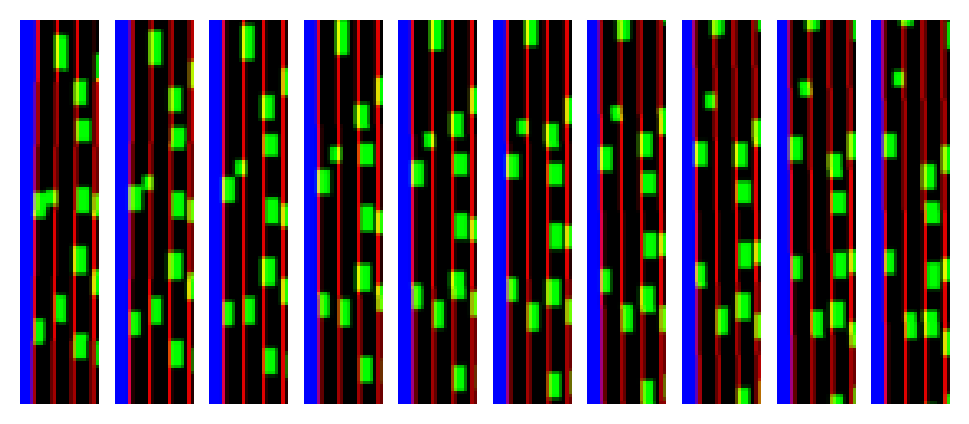

In [5]:
train_dataloader = model.train_dataloader()
batch = next(iter(train_dataloader))
batch = next(iter(train_dataloader))
batch = next(iter(train_dataloader))
plot_images(batch['target_images'])
for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()

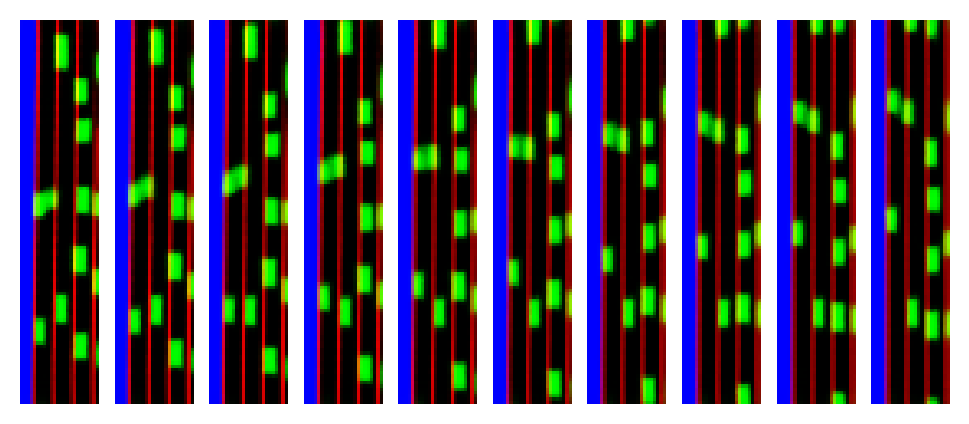

In [6]:
res = model.forward(batch)
plot_images(res['pred_images'])

In [7]:
images = res['pred_images']

images = images.detach().cpu()
images.shape

torch.Size([1, 30, 3, 117, 24])

## Gaussian filter and sharpen filter

Not sure about using sharpen filter because it's making some pixels a little too bright.

In [8]:
sharpen_filter = torch.tensor(
    [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float
).expand(3, 1, 3, 3)

In [9]:
def get_gaussian_filter(std=1, kernel_size=3):
    values = np.zeros((kernel_size, kernel_size))
    margin = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - margin
            y = j - margin
            values[i][j] = (1 / (2 * np.pi * std ** 2) * np.exp(-(x ** 2 + y ** 2) / (2 * std ** 2))).item()
    print(values.shape)
    print(values)
    values = values / values.sum()
    print(values.sum())
    return torch.from_numpy(values).expand(3, 1, kernel_size, kernel_size).float()

get_gaussian_filter(1)

(3, 3)
[[0.05854983 0.09653235 0.05854983]
 [0.09653235 0.15915494 0.09653235]
 [0.05854983 0.09653235 0.05854983]]
1.0


tensor([[[[0.0751, 0.1238, 0.0751],
          [0.1238, 0.2042, 0.1238],
          [0.0751, 0.1238, 0.0751]]],


        [[[0.0751, 0.1238, 0.0751],
          [0.1238, 0.2042, 0.1238],
          [0.0751, 0.1238, 0.0751]]],


        [[[0.0751, 0.1238, 0.0751],
          [0.1238, 0.2042, 0.1238],
          [0.0751, 0.1238, 0.0751]]]])

In [10]:
images[0].shape, sharpen_filter.shape

(torch.Size([30, 3, 117, 24]), torch.Size([3, 1, 3, 3]))

In [11]:
import torch.nn.functional as F
r = F.conv2d(images[0], sharpen_filter, groups=3, stride=1, padding=1)
r_b = F.conv2d(images[0], get_gaussian_filter(0.7, 3), groups=3, stride=1, padding=1)

(3, 3)
[[0.04219964 0.11707561 0.04219964]
 [0.11707561 0.32480601 0.11707561]
 [0.04219964 0.11707561 0.04219964]]
1.0


In [12]:
r.shape

torch.Size([30, 3, 117, 24])

In [13]:
r.max(),  images.max()

(tensor(3.3586), tensor(1.0000))

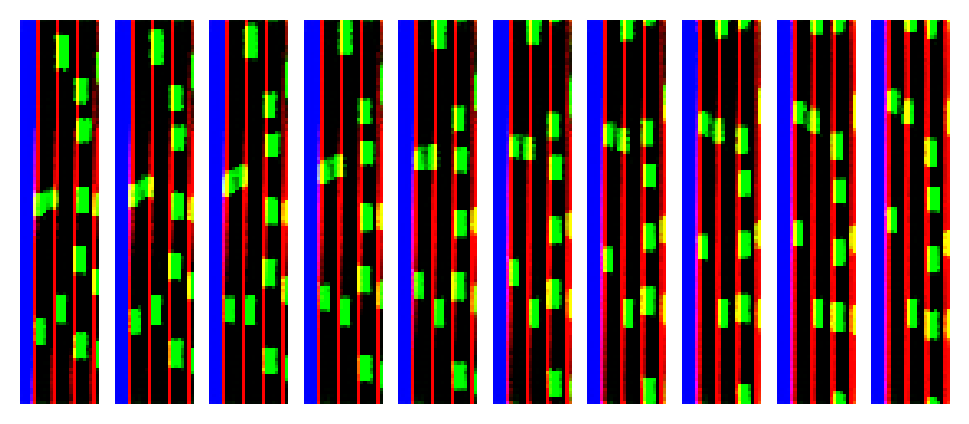

In [14]:
plot_images(r.unsqueeze(0))

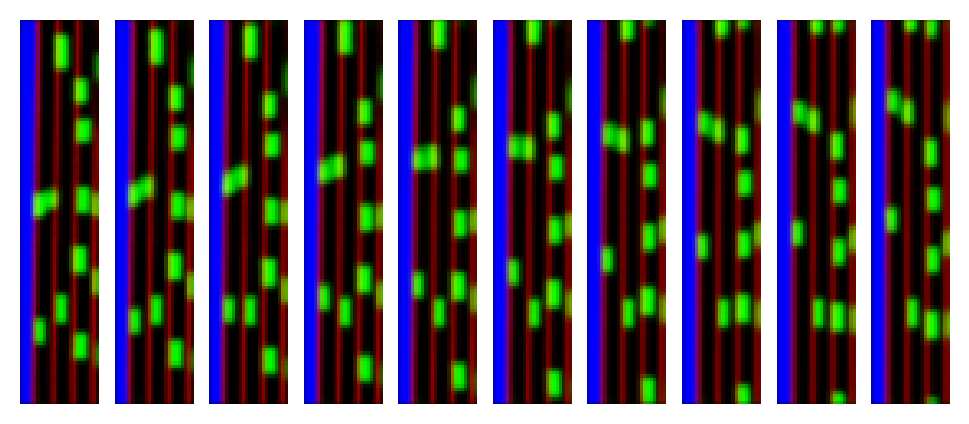

In [15]:
plot_images(r_b.unsqueeze(0))

In [16]:
r2 = images + torch.rand(*images.shape) * 0.1

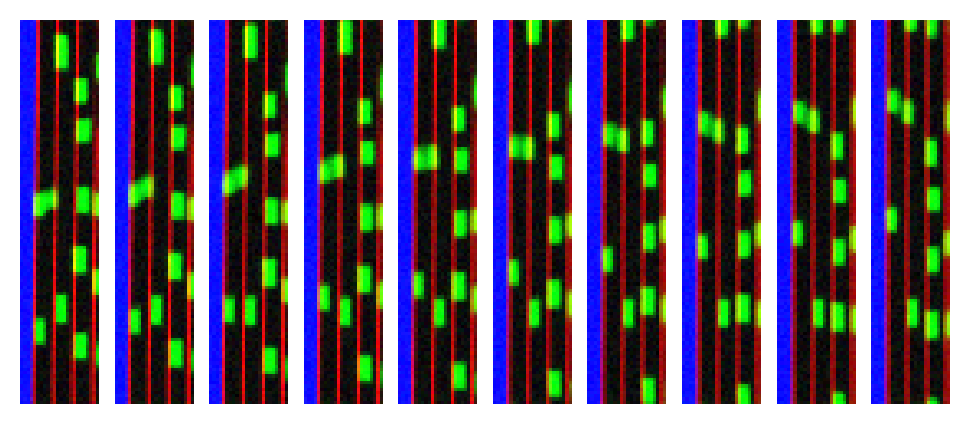

In [17]:
plot_images(r2)

In [18]:
r2.max()
r2.min()

tensor(1.7762e-05)

### Gaussian Noise filter

In [19]:

r3 = images + torch.normal(torch.zeros(*images.shape), std=.07)

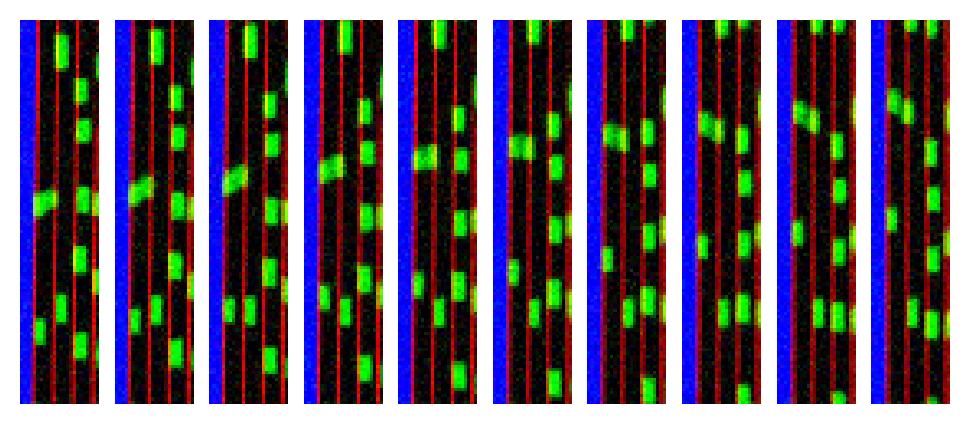

In [20]:
plot_images(r3)

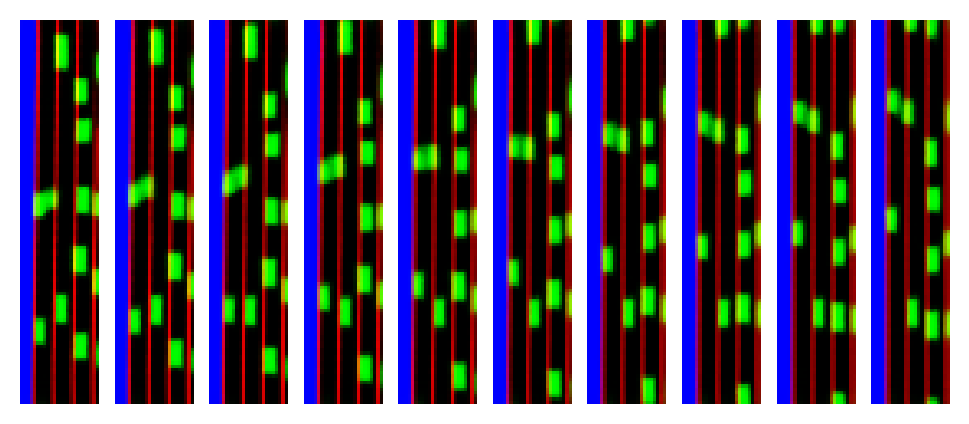

In [21]:
plot_images(images)

In [22]:
torch.rand(1).item()

0.8550702333450317

# Testing the augmenter class

In [93]:
import ppuu.data.augmentations
imp.reload(ppuu.data.augmentations)

a = ppuu.data.augmentations.Augmenter(p=1.0)
aug_img = a(images)

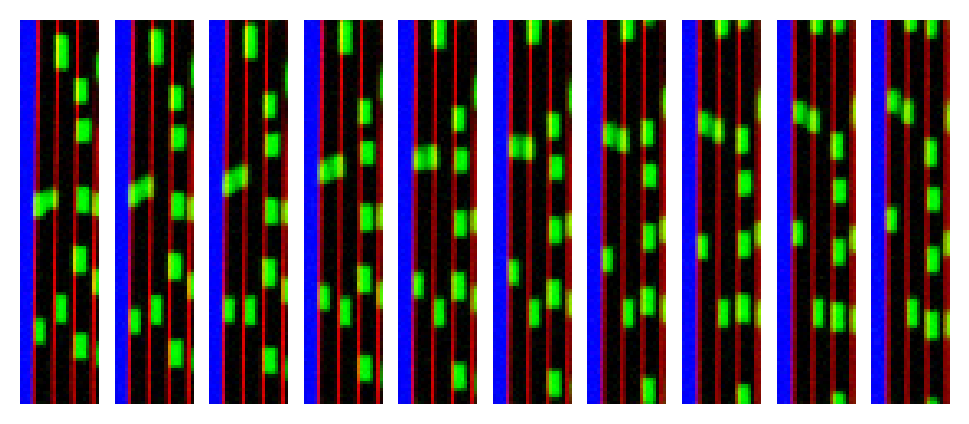

In [94]:
plot_images(aug_img)

In [ ]:
import numpy as np
np.random.randint(1, 3)

In [57]:
np.random.choice([1, 2], replace=False, size=1)

array([2])

In [47]:
max([np.random.randint(1, 3) for _  in range(100)])

2